In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def display_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 3) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def display_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for mask in masks:
        display_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()
    del mask
    gc.collect()

def display_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def display_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(raw_image)
    for box in boxes:
        display_box(box, plt.gca())
    plt.axis('on')
    plt.show()


In [2]:
pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.9 MB/s eta 0:00:00


In [3]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
from transformers import SamModel, SamProcessor
from transformers import pipeline as huggingface_pipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

yolo_processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
yolo_model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

pipeline = huggingface_pipeline(task="image-classification", model=sam_model, image_processor=sam_processor, device=device)


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


The model 'SamModel' is not supported for image-classification. Supported models are ['BeitForImageClassification', 'BitForImageClassification', 'ConvNextForImageClassification', 'ConvNextV2ForImageClassification', 'CvtForImageClassification', 'Data2VecVisionForImageClassification', 'DeiTForImageClassification', 'DeiTForImageClassificationWithTeacher', 'DinatForImageClassification', 'EfficientFormerForImageClassification', 'EfficientFormerForImageClassificationWithTeacher', 'EfficientNetForImageClassification', 'FocalNetForImageClassification', 'ImageGPTForImageClassification', 'LevitForImageClassification', 'LevitForImageClassificationWithTeacher', 'MobileNetV1ForImageClassification', 'MobileNetV2ForImageClassification', 'MobileViTForImageClassification', 'MobileViTV2ForImageClassification', 'NatForImageClassification', 'PerceiverForImageClassificationLearned', 'PerceiverForImageClassificationFourier', 'PerceiverForImageClassificationConvProcessing', 'PoolFormerForImageClassification'

In [5]:
import zipfile

zip_path = '/content/birds.zip'
extract_path = '/content/images'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_path)


In [6]:
from PIL import Image

zip_path = '/content/birds.zip'  # Replace with the actual path to your ZIP file

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_file:
    # Iterate over the files in the ZIP file
    for file_name in zip_file.namelist():
        # Check if the file is a JPEG image
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg'):
            # Extract the image file
            zip_file.extract(file_name, './extracted_images')

            # Open the extracted image file using Image.open()
            image_path = f'./extracted_images/{file_name}'
            image1 = Image.open(image_path)



[{'scores': tensor([0.9931], grad_fn=<IndexBackward0>), 'labels': tensor([16]), 'boxes': tensor([[  9.6004,   0.8032, 223.7991, 224.5876]], grad_fn=<IndexBackward0>)}]
Detected 16 | bird with confidence 0.993 at location [9.6, 0.8, 223.8, 224.59]


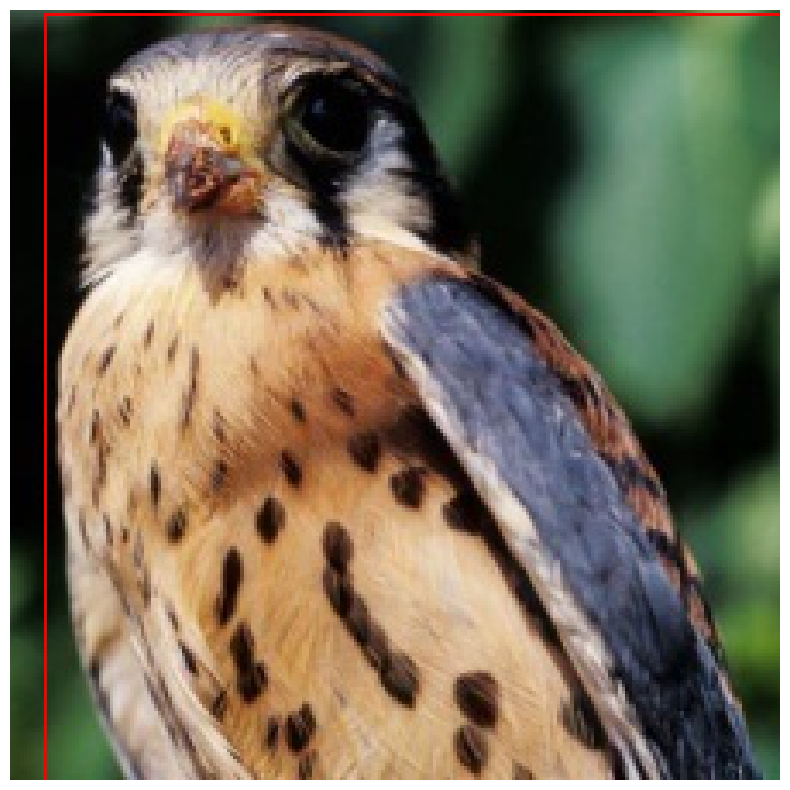

In [9]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0, x1, y1 = box
    rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    for box in boxes:
        show_box(box, ax)
    plt.axis('off')
    plt.show()

# Rest of the code

inputs_yolo = yolo_processor(images=image1, return_tensors="pt")
outputs_yolo = yolo_model(**inputs_yolo)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes_yolo = torch.tensor([image1.size[::-1]])
raw_result_yolo = yolo_processor.post_process_object_detection(outputs_yolo, threshold=0.9, target_sizes=target_sizes_yolo)
results_yolo = raw_result_yolo[0]
print(raw_result_yolo)

for score_yolo, label_yolo, box_yolo in zip(results_yolo["scores"], results_yolo["labels"], results_yolo["boxes"]):
    box_yolo = [round(i, 2) for i in box_yolo.tolist()]
    print(
        f"Detected {label_yolo.item()} | {yolo_model.config.id2label[label_yolo.item()]} with confidence "
        f"{round(score_yolo.item(), 3)} at location {box_yolo}"
    )
    show_boxes_on_image(image1, [box_yolo])




In [16]:
input_boxes = [np.ndarray.tolist(results_yolo["boxes"].detach().numpy())]
inputs = sam_processor(image1, input_boxes=input_boxes, return_tensors="pt").to(device)
image_embeddings = sam_model.get_image_embeddings(inputs["pixel_values"])

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = sam_model(**inputs)

masks = sam_processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

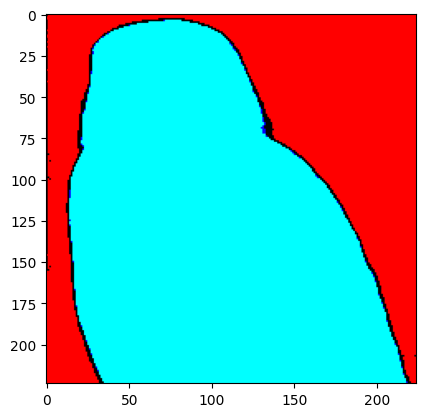

In [17]:
mask_plot = []
for index, mask in enumerate(masks[0]):
    mask_plot = (mask_plot == True) | (mask[:, :, :] == True)

mask_plot = mask_plot.float()
plt.imshow(mask_plot.permute(1, 2, 0))

In [18]:
!pip install diffusers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00


In [19]:
import torch
from diffusers import StableDiffusionInpaintPipeline

pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float32)

safety_checker/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import torchvision.transforms as T
from PIL import Image

tensor = mask_plot
transform = T.ToPILImage()
mask_image = transform(tensor).resize((512, 512))
init_image = image1.resize((512, 512))

prompt = 'bird flying near a birfeeder'
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

plt.imshow(np.array(image))
plt.axis('off')
plt.show()


NameError: ignored

In [ ]:
from PIL import Image
import numpy as np

plt.imsave('./new.jpeg', np.array(image))

FileNotFoundError: ignored